**1)**
Set up the parameters

In [1]:
using Distributions
using PlotlyJS
using Random

# --- DDM Parameters ---
k = 0.3  # Drift rate (evidence accumulation rate)
σ = 1.0   # Noise standard deviation
B = 2.0   # Decision boundary
dt = 0.001 # Time step
max_t = 5.0 # Maximum simulation time
max_t_steps = Int(max_t/dt)

5000

**2)**
Here is the main function for simulating DDM

In [2]:
# --- Simulation Function ---
function simulate_ddm(k, σ, B, dt, max_t)
    x = 0.0  # Initial decision variable
    xs = zeros(max_t_steps)
    r = 0    # undetermined
    t_step = 1

    while abs(x) < B && t_step < max_t_steps
        dx = k * dt + σ * randn() * sqrt(dt) # Euler-Maruyama integration
        x += dx
        xs[t_step] = x
        t_step = t_step + 1
    end
    if x>=B
        r=1
        xs[t_step:max_t_steps] .= B
    elseif x<=-B
        r=-1
        xs[t_step:max_t_steps] .= -B
    end
    return t_step * dt, xs, r # 1 for upper boundary, -1 for lower
end

simulate_ddm (generic function with 1 method)

**3)**
Let's run a bunch of simulations, recording the reaction times and the average drifting trajectory.

In [3]:
# --- Run Multiple Trials ---
n_trials = 10000
decisions = zeros(Int, n_trials)
rts_correct = []
rts_error = []
n_correct = n_error = 0
trace_correct = zeros(max_t_steps)
trace_error = zeros(max_t_steps)

for i in 1:n_trials
    rt, xs, decision = simulate_ddm(k, σ, B, dt, max_t)
    # rt表示当前trial的反应时间，
    decisions[i] = decision
    # Record reaction time
    if decision == 1 
        push!(rts_correct, rt) 
        # push! 操纵是将 rt 加入到 rts_correct 数组中
        n_correct = n_correct + 1
        trace_correct = ((n_correct-1) * trace_correct + xs) / n_correct
        # 计算平均轨迹
    elseif decision == -1
        push!(rts_error, rt)
        n_error = n_error + 1
        trace_error = ((n_error-1) * trace_error + xs) / n_error
    end
end

**4)**
Generating the plots

┌ Warning: attempting to remove probably stale pidfile
│   path = /Users/crazybread/.jlassetregistry.lock
└ @ Pidfile /Users/crazybread/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


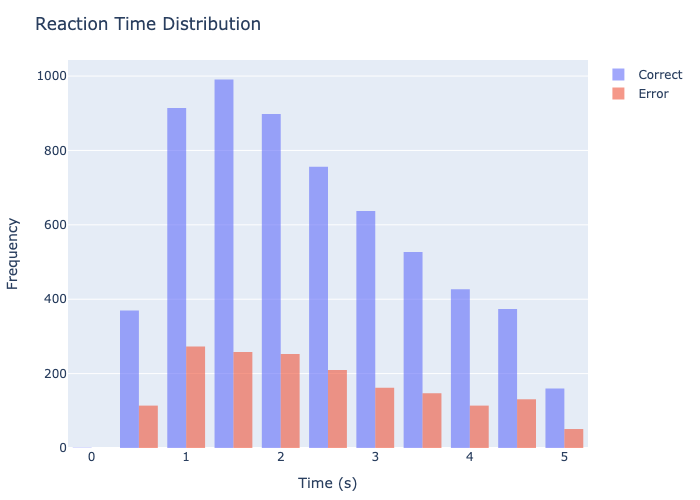

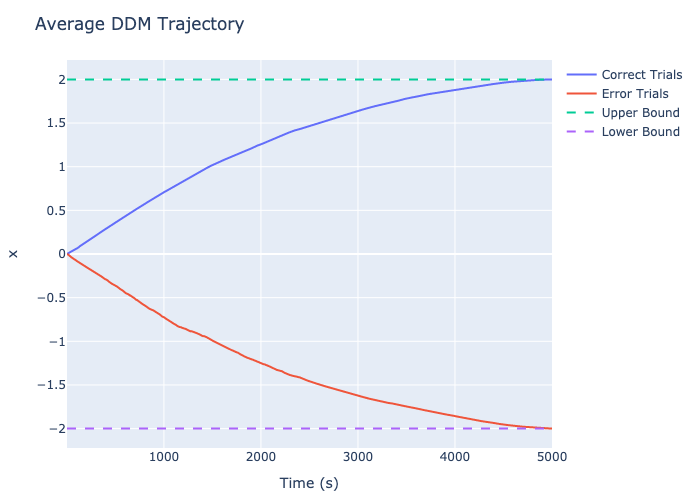

Accuracy: 0.7794799176107106
Mean RT (correct): 2.345732947976879
Mean RT (error): 2.365566841798013


In [4]:
# Reaction Time Histogram
histogram_correct = histogram(x=rts_correct, nbinsx=20, name="Correct", opacity=0.6)
histogram_error = histogram(x=rts_error, nbinsx=20, name="Error", opacity=0.6)

layout_hist = Layout(title="Reaction Time Distribution", xaxis_title="Time (s)", yaxis_title="Frequency", bar_mode="overlay")
display(plot([histogram_correct, histogram_error], layout_hist))

# Average Drifting Trajectories for the 2 choices
trajectory_correct = scatter(x=1:max_t_steps, y=trace_correct, mode="lines", name="Correct Trials")
trajectory_error = scatter(x=1:max_t_steps, y=trace_error, mode="lines", name="Error Trials")
upper_bound = scatter(x=[1, max_t_steps], y=[B,B], mode="lines", name="Upper Bound", line=attr(dash="dash"))
lower_bound = scatter(x=[1, max_t_steps], y=[-B,-B], mode="lines", name="Lower Bound", line=attr(dash="dash"))

layout_traj = Layout(title="Average DDM Trajectory", xaxis_title="Time (s)", yaxis_title="x")

display(plot([trajectory_correct, trajectory_error, upper_bound, lower_bound], layout_traj))


# --- Analysis (Example: Accuracy and Mean RT) ---
accuracy = n_correct / (n_correct + n_error) # Assuming '1' is the correct choice

println("Accuracy: ", accuracy)
println("Mean RT (correct): ", mean(rts_correct))
println("Mean RT (error): ", mean(rts_error))


**5)**
Now let's use DDM to simulate the random dots experiment. We will include 6 coherence levels, test the model accuracies and reaction times

In [5]:
B = 3
drift_rate = 6
σ = 2
time_non_decision = 0.3
coherences = [-0.512, -.256, -.128, -.064, -.032, 0, +.032, +.064, +.128, +.256, +.512]
n_coherences = length(coherences)

total_trials = 10000

#simulating DDM

choices = []
rts = []
for coh in coherences
    push!(choices,[])
    push!(rts,[])
end

for trial in 1:total_trials
    accum = 0
    rt = 0
    coh_i = rand(1:n_coherences)
    coh = coherences[coh_i]
#    print(coh)
    
    rt, xs, decision = simulate_ddm(drift_rate * coh, σ, B, dt, max_t*2)
    # coherence 作用是改变 drift rate的大小
    if decision!=0 
        push!(choices[coh_i], decision/2+0.5)    # convert decision into 0 and 1
        push!(rts[coh_i], rt + time_non_decision)
    end
end

p_right=[]
rt=[]
for coh_i in 1:n_coherences
    if length(choices[coh_i])>0
        push!(p_right, mean(choices[coh_i]))
        push!(rt, mean(rts[coh_i]))
    else
        push!(p_right,-1)
        push!(rt,0)
    end
end

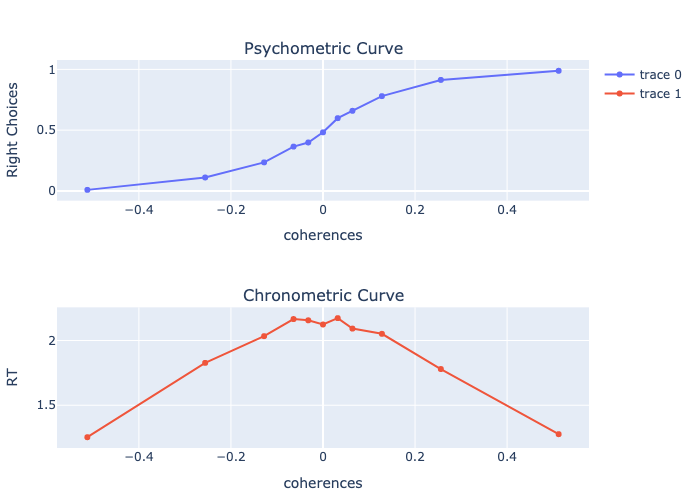

In [9]:
p1 = plot(coherences, p_right, Layout(title="Psychometric Curve",xaxis_title="coherences", yaxis_title="Right Choices"))
#plt.ylabel('Right%')
p2 = plot(coherences, rt, Layout(title="Chronometric Curve",xaxis_title="coherences", yaxis_title="RT"))
p = [p1; p2] 